In [ ]:
!pip install pandas
!pip install qiskit==0.39.2
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scipy


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
import shin_metiu_full as sf
import matplotlib as mpl

# import ipywidgets as widgets
import pandas as pd
import seaborn as sns

from ansatze import hweff_ansatz
from qiskit import Aer
from exact_simulator import prep_ham, simulation, inner

from auto_plotter import autoplotter, prep_dfs
import warnings

mpl.rcParams['text.usetex'] = False

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")
sns.set_context(
    "talk",
    rc={
        "text.usetex": True,
        "font.size": 18,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "legend.loc": "lower left",
        "legend.frameon": False,
        "font.family": "serif",
        "font.serif": "Times New Roman",
    },
)
file = "results/LONG0.json"
data = json.load(open(file))
backend = Aer.get_backend("statevector_simulator")
data.keys()

In [ ]:
numfiles = 150
max_times =700
results = []
dfs = []
fin_files = 0
for d in range(3, 6):
    for tr in [1,2,3,4,10]:
        for r in range(10):
            try:
                file = f"results/depth_trotter_an/d_{d}_tr_{tr}_rep{r}.json"
                data = json.load(open(file))
                if data['final_i'] < 1000:
                    print('not_complte')
                    raise('not complete')
                results.append(data)
                for j in ['QC','ideal','exact']:
                    datadf = pd.DataFrame(data[f'{j}_coefficients'])
                    datadf = datadf.reset_index()
                    datadf = datadf.melt(id_vars='index',var_name='Adiabatic state',value_name='Population')
                    datadf['Setup:'] = f'{j}'
                    datadf['sample'] = fin_files
                    datadf['Depth'] = data['depth']
                    datadf['Trotter Steps'] = data['trotter_steps']
                    datadf['Time'] = datadf['index']*data['dt']
                    dfs.append(datadf)
                fin_files+=1
            except:
                print(f"didn't find {d},{tr},{r}")
numfiles=fin_files
datadf = pd.concat(dfs,ignore_index=True)
stuff = [
    "fidelity_to_ideal",
    "fidelity_to_exact",
    "ideal_forces_el",
    "ideal_forces_nuc",
    "ideal_tot_forces",
    "ideal_velocities",
    "ideal_positions",
    "ideal_energy_el",
    "ideal_energy_Tnuc",
    "ideal_energy_Vnuc",
    "exact_forces_el",
    "exact_forces_nuc",
    "exact_tot_forces",
    "exact_velocities",
    "exact_positions",
    "exact_energy_el",
    "exact_energy_Tnuc",
    "exact_energy_Vnuc",
    "QC_forces_el",
    "QC_forces_nuc",
    "QC_tot_forces",
    "QC_velocities",
    "QC_positions",
    "QC_energy_el",
    "QC_energy_Tnuc",
    "QC_energy_Vnuc",
    "force",
    "err_force",
    "energy",
    "err_energy",
    "init_F",
    "final_F",
    "err_init_F",
    "err_fin_F",
    "iter_number",
    "times",
    'depth',
    'trotter_steps'
]

store = {i: [] for i in stuff}
store["sample"] = []

for i in range(numfiles):
    for j in stuff:
        try:
            store[j].extend(results[i][j][0:max_times])
        except:
            store[j].extend([results[i][j]]*max_times)
        
        # print(len(store[j]))
    store["sample"].extend([i] * max_times)
# print(len(store["sample"]))

df = pd.DataFrame(store)
df["diff_ideal_exact"] = np.abs(df["fidelity_to_exact"] - df["fidelity_to_ideal"])
df['QC_energy'] = df['QC_energy_el']+df['QC_energy_Vnuc']+df['QC_energy_Tnuc']
df['ideal_energy'] = df['ideal_energy_el']+df['ideal_energy_Vnuc']+df['ideal_energy_Tnuc']
df['exact_energy'] = df['exact_energy_el']+df['exact_energy_Vnuc']+df['exact_energy_Tnuc']

coeff_names  ={'exact_coefficients':'Exact',
'ideal_coefficients':'Ideal',
'QC_coefficients': 'TDVQP'}

store_coef = {coeff_names[i]: [] for i in coeff_names}
store_coef['Time'] = []
store_coef['State'] = []
store_coef["Sample"] = []
for i in range(numfiles):
    for j in coeff_names:
        for k, res in enumerate(results[i][j][0:max_times]):        
            store_coef[coeff_names[j]].extend(res[0:15]) # only really need highest 5 populations even in larger simulations with superpositions.
            if j == 'exact_coefficients':
                store_coef['Time'].extend([results[i]['times'][k]]*15)
                store_coef["Sample"].extend([i] * 15)
                store_coef['State'].extend(list(range(15)))
                
df_coef = pd.DataFrame(store_coef).melt(id_vars=('Time','State','Sample'),value_name='Population',var_name='Type')
df = df.rename({'depth':'Depth','trotter_steps':'Trotter Steps'}, axis='columns')
dash_list = sns._core.unique_dashes(df['sample'].unique().size+1)
style = {key:value for key,value in zip(df['sample'].unique(), dash_list[1:])}

# Figure S5

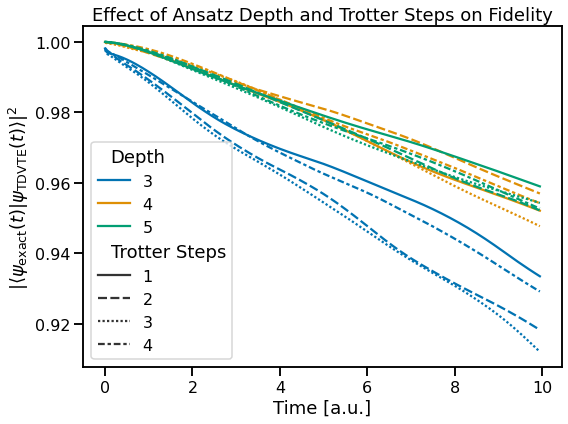

In [8]:
fig, ax = plt.subplots(figsize=((8, 6)))
sns.lineplot(data=df.query('times<10 & `Trotter Steps` < 10'), x="times", y="fidelity_to_ideal", ci=None, estimator='mean', ax=ax, hue='Depth',style='Trotter Steps',palette=sns.color_palette('colorblind'))#, label = 'compared to exact evoltuion of VQE state')
# sns.lineplot(data=df, x="times", y="fidelity_to_ideal", ci="sd", ax=ax, label= 'compared to ideal state evolution')
# plt.ylabel('Fidelity')
ax.set(ylabel=r'$\left |\langle\psi_\mathrm{exact}(t)|\psi_\mathrm{TDVQP}(t)\rangle\right |^2 $',xlabel= r'Time [a.u.]')
plt.title('Effect of Ansatz Depth and Trotter Steps on Fidelity')
plt.tight_layout()

plt.savefig("custom_plots/depth_trotter_fidelity.pdf")